<a href="https://colab.research.google.com/github/LucasColas/CNN-VS-ViT/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

In [ ]:
!pip install medmnist

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from medmnist import OCTMNIST  # Import the OCTMNIST dataset

## Architecture

### ResidualBlock

In [1]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 activation=nn.ReLU(inplace=True), use_batchnorm=True):
        super(ResidualBlock, self).__init__()

        padding = kernel_size // 2  # To keep spatial dimensions constant

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               padding=padding, bias=not use_batchnorm)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                               padding=padding, bias=not use_batchnorm)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # Define the activation function
        self.activation = activation

        # If input and output channels differ, use a 1x1 conv to match dimensions
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.activation(out)
        return out




## ResNet

In [2]:
class CustomResNet(nn.Module):
    def __init__(self,
                 in_channels=3,         # Input channels (e.g., 3 for RGB images)
                 num_blocks=4,          # Number of residual blocks
                 base_channels=64,      # Number of channels for the first block
                 kernel_size=3,         # Kernel size for convolutions
                 activation=nn.ReLU(inplace=True),  # Activation function
                 use_batchnorm=True,    # Whether to use BatchNorm
                 num_classes=10         # Number of classes for final output
                 ):
        super(CustomResNet, self).__init__()

        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=kernel_size,
                                      padding=kernel_size//2, bias=not use_batchnorm)
        self.initial_bn = nn.BatchNorm2d(base_channels) if use_batchnorm else nn.Identity()
        self.activation = activation

        # Create a sequential container for residual blocks.
        layers = []
        # First block: input channels = base_channels, output channels = base_channels
        for _ in range(num_blocks):
            layers.append(ResidualBlock(base_channels, base_channels,
                                        kernel_size=kernel_size,
                                        activation=activation,
                                        use_batchnorm=use_batchnorm))
        self.residual_layers = nn.Sequential(*layers)

        # Global average pooling and a final linear classifier.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.activation(x)

        x = self.residual_layers(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CustomResNet(
        in_channels=3,
        num_blocks=5,               # You can choose how many blocks
        base_channels=64,
        kernel_size=3,              # Kernel size can be adjusted
        activation=nn.LeakyReLU(0.1, inplace=True),  # You can choose any activation
        use_batchnorm=True,         # Toggle batch normalization
        num_classes=1000            # For example, for ImageNet classification
    )

model = model.to(device)
print(model)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)

Using device: cuda
CustomResNet(
  (initial_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Training

In [4]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

Train dataset size: 97477
Test dataset size: 1000


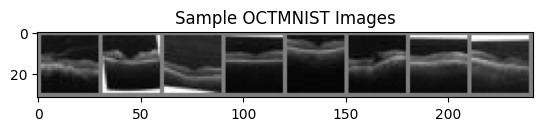

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Normalize for a single channel (grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Download the OCTMNIST dataset.
train_dataset = OCTMNIST(split='train', transform=transform, download=True)
test_dataset  = OCTMNIST(split='test', transform=transform, download=True)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Create data loaders.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Visualize a few training samples
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), title="Sample OCTMNIST Images")


In [12]:

# Training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet(
    in_channels=1,
    num_blocks=5,               # adjust number of blocks as desired
    base_channels=64,
    kernel_size=3,
    activation=nn.LeakyReLU(0.1, inplace=True),  # choose your activation function
    use_batchnorm=True,
    num_classes=4               # OCTMNIST has 4 classes
)
model = model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5  # adjust as necessary

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:  # print every 20 mini-batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/20:.4f}")
            running_loss = 0.0

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.squeeze().to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru